In [10]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numbers

from functools import partial
from threading import Thread
from tornado import gen

from PIL import Image


In [2]:
root = '../../data/raw/digit-recognizer/'
SEED = 42
np.random.seed(SEED)
n_pixels = 28 * 28

In [11]:
class MNIST_data(Dataset):
    
    def __init__(self, file_path, transform=None):
        
        df = pd.read_csv(file_path)
        
        if len(df.columns) == n_pixels:
            # test data
            self.X = df.values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = None
        else:
            # training data
            self.X = df.iloc[:,1:].values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = torch.from_numpy(df.iloc[:,0].values)
            
        self.transform = transform
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y:
            return self.transform(self.X[idx]), self.y[idx]
        else:
            return self.transform(self.X[idx])

In [4]:
class RandomRotation:
    def __init__(self, degrees, resample=False, expand=False, center=None):
        if isinstance(degrees, numbers.Number):
            if degrees < 0:
                raise ValueError("If degrees is a single number, it must be positive.")
            self.degrees = (-degrees, degrees)
        else:
            if len(degrees) != 2:
                raise ValueError("If degrees is a sequence, it must be of len 2.")
            self.degrees = degrees

        self.resample = resample
        self.expand = expand
        self.center = center

    @staticmethod
    def get_params(degrees):
        angle = np.random.uniform(degrees[0], degrees[1])
        return angle

    def __call__(self, img):        
        def rotate(img, angle, resample=False, expand=False, center=None):
            return img.rotate(angle, resample, expand, center)

        angle = self.get_params(self.degrees)
        return rotate(img, angle, self.resample, self.expand, self.center)

In [5]:
class RandomShift(object):
    def __init__(self, shift):
        self.shift = shift
        
    @staticmethod
    def get_params(shift):
        hshift, vshift = np.random.uniform(-shift, shift, size=2)
        return hshift, vshift 
    
    def __call__(self, img):
        hshift, vshift = self.get_params(self.shift)
        return img.transform(img.size, Image.AFFINE, (1,0,hshift,0,1,vshift), resample=Image.BICUBIC, fill=1)

In [6]:
batch_size = 64
train_split = .7
shuffle_dataset = True
random_seed= 42
np.random.seed(random_seed)

    
full_train_dataset = MNIST_data(root + 'train.csv', transform=transforms.Compose([
    transforms.ToPILImage(), 
#     RandomRotation(degrees=20), 
#     RandomShift(3),
    transforms.ToTensor(), 
    transforms.Normalize(mean=(0.5,), std=(0.5,))
]))

# train_len = int(train_split * len(full_train_dataset))
# valid_len = len(full_train_dataset) - train_len
# train_dataset, valid_dataset = random_split(full_train_dataset, lengths=[train_len, valid_len])
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)

full_train_loader = torch.utils.data.DataLoader(dataset=full_train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST_data(root + 'test.csv', transforms.Compose([
    transforms.ToPILImage(), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=(0.5,), std=(0.5,))
]))
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [7]:
# Create Logistic Regression Model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        # Linear part
        self.linear = nn.Linear(input_dim, output_dim)
        # There should be logistic function right?
        # However logistic function in pytorch is in loss function
        # So actually we do not forget to put it, it is only at next parts
    
    def forward(self, x):
        out = self.linear(x)
        return out

In [8]:
# Instantiate Model Class
input_dim = 28*28 
# size of image px*px
output_dim = 10  
# labels 0,1,2,3,4,5,6,7,8,9

# create logistic regression model
model = LogisticRegressionModel(input_dim, output_dim)

# Cross Entropy Loss  
loss_fn = nn.CrossEntropyLoss()

# SGD Optimizer 
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [9]:
i, l = iter(full_train_loader)

RuntimeError: bool value of Tensor with more than one value is ambiguous

In [ ]:
num_epochs = 15

train_loss_history = []
train_correct_history = []
valid_loss_history = []
valid_correct_history = []
for epoch in range(num_epochs):
    
    current_train_loss = 0.0
    current_train_correct = 0.0
    current_valid_loss = 0.0
    current_valid_correct = 0.0
    for images, labels in full_train_loader:
        
        # Define variables
        train = Variable(images.view(-1, 28*28))
        labels = Variable(labels)
        
        optimizer.zero_grad()
        outputs = model(train)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = torch.max(y_hat, 1)[1]
        current_train_loss += loss.item()
        current_train_correct += torch.sum(preds == labels.data)
        
        # Calculate Accuracy         
        correct = 0
        total = 0
#     else:
#         with torch.no_grad():
#             for val_images, val_labels in validation_loader: 
#                 test = Variable(images.view(-1, 28*28))
#                 outputs = model(val_images)
                
#                 val_loss = loss_fn(y_val, val_labels)
                
#                 preds = torch.max(y_val, 1)[1]
#                 current_valid_loss += val_loss.item()
#                 current_valid_correct += torch.sum(preds == val_labels.data)

        epoch_loss = current_train_loss/len(training_loader.dataset)
        epoch_acc = current_train_correct.float()/len(training_loader)
        train_loss_history.append(epoch_loss)
        train_correct_history.append(epoch_acc)
        print(f"training loss: {epoch_loss}, training accuracy: {epoch_acc}")
#         epoch_loss = current_valid_loss/len(validation_loader.dataset)
#         epoch_acc = current_valid_correct.float()/len(validation_loader)
#         valid_loss_history.append(epoch_loss)
#         valid_correct_history.append(epoch_acc)
#         print(f"validation loss: {epoch_loss}, validation accuracy: {epoch_acc}")

In [ ]:
plt.plot(train_correct_history, label="train_correct_history")
plt.plot(valid_correct_history, label="valid_correct_history")
plt.legend()

In [15]:
# Create ANN Model
class ANNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANNModel, self).__init__()
        # Linear function 1: 784 --> 100
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        # Non-linearity 1
        self.relu1 = nn.ReLU()
        
        # Linear function 2: 100 --> 100
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 2
        self.tanh2 = nn.Tanh()
        
        # Linear function 3: 100 --> 100
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 3
        self.elu3 = nn.ELU()
        
        # Linear function 4 (readout): 100 --> 10
        self.fc4 = nn.Linear(hidden_dim, output_dim)  
    
    def forward(self, x):
        # Linear function 1
        out = self.fc1(x)
        # Non-linearity 1
        out = self.relu1(out)
        
        # Linear function 2
        out = self.fc2(out)
        # Non-linearity 2
        out = self.tanh2(out)
        
        # Linear function 2
        out = self.fc3(out)
        # Non-linearity 2
        out = self.elu3(out)
        
        # Linear function 4 (readout)
        out = self.fc4(out)
        return out

# instantiate ANN
input_dim = 28*28
hidden_dim = 150 #hidden layer dim is one of the hyper parameter and it should be chosen and tuned. For now I only say 150 there is no reason.
output_dim = 10

# Create ANN
model = ANNModel(input_dim, hidden_dim, output_dim)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.02
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [17]:
# ANN model training
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        train = Variable(images.view(-1, 28*28))
        labels = Variable(labels)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1
        
        if count % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Predict test dataset
            for images, labels in test_loader:

                test = Variable(images.view(-1, 28*28))
                
                # Forward propagation
                outputs = model(test)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)

                # Total correct predictions
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            if count % 500 == 0:
                # Print Loss
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

Iteration: 500  Loss: 0.40841883420944214  Accuracy: 88.32142639160156 %
Iteration: 1000  Loss: 0.3520560562610626  Accuracy: 90.0 %
Iteration: 1500  Loss: 0.17758281528949738  Accuracy: 91.10713958740234 %
Iteration: 2000  Loss: 0.249117910861969  Accuracy: 91.86904907226562 %
Iteration: 2500  Loss: 0.259649395942688  Accuracy: 92.79762268066406 %
Iteration: 3000  Loss: 0.1055479645729065  Accuracy: 93.5 %
Iteration: 3500  Loss: 0.22073550522327423  Accuracy: 93.95237731933594 %
Iteration: 4000  Loss: 0.052280016243457794  Accuracy: 94.45237731933594 %
Iteration: 4500  Loss: 0.2555612325668335  Accuracy: 94.67857360839844 %
Iteration: 5000  Loss: 0.09456729888916016  Accuracy: 94.98809814453125 %
Iteration: 5500  Loss: 0.18264976143836975  Accuracy: 94.95237731933594 %
Iteration: 6000  Loss: 0.16012339293956757  Accuracy: 95.19047546386719 %
Iteration: 6500  Loss: 0.09327534586191177  Accuracy: 95.57142639160156 %
Iteration: 7000  Loss: 0.12597736716270447  Accuracy: 95.9047622680664 

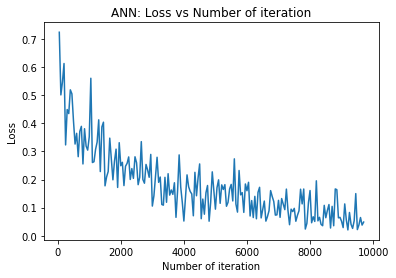

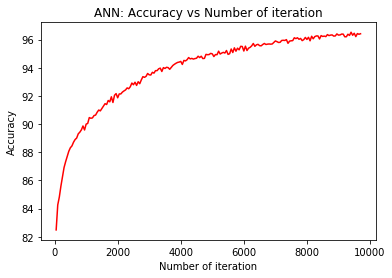

In [19]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("ANN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("ANN: Accuracy vs Number of iteration")
plt.show()

In [22]:
# Create CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
     
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected 1
        self.fc1 = nn.Linear(32 * 4 * 4, 10) 
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        
        # Max pool 1
        out = self.maxpool1(out)
        
        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)
        
        # Max pool 2 
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)
        
        return out

# batch_size, epoch and iteration
batch_size = 100
n_iters = 2500
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)
    
# Create ANN
model = CNNModel()

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [23]:
# CNN model training
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        train = Variable(images.view(100,1,28,28))
        labels = Variable(labels)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        count += 1
        if count % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                
                test = Variable(images.view(100,1,28,28))
                
                # Forward propagation
                outputs = model(test)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            if count % 500 == 0:
                # Print Loss
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

Iteration: 500  Loss: 0.12418103218078613  Accuracy: 96.38095092773438 %
Iteration: 1000  Loss: 0.06240645423531532  Accuracy: 97.72618865966797 %
Iteration: 1500  Loss: 0.041472841054201126  Accuracy: 97.66666412353516 %
Iteration: 2000  Loss: 0.014997249469161034  Accuracy: 98.19047546386719 %


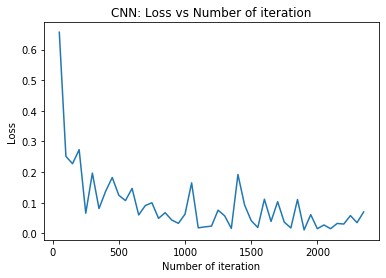

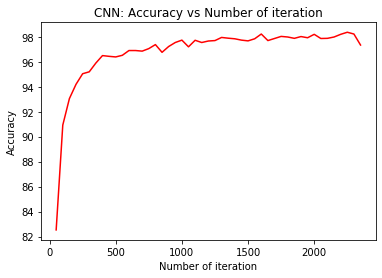

In [24]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()